# Punto 1: Word2vec

Expectativas:
- Uso de Word2Vec 
- Responder:
    - ¿Su modelo da buenos resultados? ¿Por qué sí o por qué no?
    - ¿Qué problemas encontró al realizar este taller?

- Librerias:

In [28]:
import re
import numpy as np
import sys
import pandas as pd

from nltk.corpus import stopwords
stopwords_sp = stopwords.words('spanish')
stopwords_eg = stopwords.words('english')

from nltk.stem.snowball import SnowballStemmer
spanishStemmer=SnowballStemmer("spanish") # carga de raices en español

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics.pairwise import euclidean_distances
import nltk

import gensim.models.word2vec as w2v
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot

- Funciones:

In [62]:
def quitar_tildes(s):
    tildes = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
    )
    for origen, destino in tildes:
        s = s.replace(origen, destino)
    return s

In [63]:
def Preprocesamiento_sp(s):
    
    texto_min = s.lower() # minúsculas
    texto_l = re.sub(r"[\W\d_]+", " ",texto_min) # remove caract, números
    texto_sint = quitar_tildes(texto_l) # remove tildes
    texto_t = texto_sint.split() # tokenizar
    texto_stopW = [palabra for palabra in texto_t if palabra not in stopwords_sp] # stopwords
    #texto_stem = [spanishStemmer.stem(palabra) for palabra in texto_stopW] # stemming
    texto_procesado = " ".join(texto_stopW)
    
    return texto_procesado.split()

In [64]:
def Preprocesamiento_eg(s):
    
    texto_min = s.lower() # minúsculas
    texto_l = re.sub(r"[\W\d_]+", " ",texto_min) # remove caract, números
    #texto_sint = quitar_tildes(texto_l) # remove tildes
    texto_t = texto_l.split() # tokenizar
    texto_stopW = [palabra for palabra in texto_t if palabra not in stopwords_eg] # stopwords
    #texto_stem = [spanishStemmer.stem(palabra) for palabra in texto_stopW] # stemming
    texto_procesado = " ".join(texto_stopW)
    
    return texto_procesado.split()

In [114]:
def nearest_similarity_cosmul(mi_modelo, start1, end1, end2):
    similarities = mi_modelo.wv.most_similar_cosmul(
                        positive=[end2, start1],
                        negative=[end1]
                        )
    start2 = similarities[0][0]
    print("{0} es a {1}, lo que {2} es a {3}".format(start1, end1, start2, end2))

## Base de Discursos:

- Mas información de discursos en inglés aqui: https://www.americanrhetoric.com/speechbank.htm 

- Mas información de discursos en español aqui : https://www.retoricas.com/2009/12/autores.html

In [61]:
# lectura de archivo
Discursos = pd.read_excel('Discursos.xlsx')
Discursos.head()

,personaje,titulo,discurso
0,Salvador Allende,Último discurso de salvador allende desde la c...,Compatriotas: es posible que silencien las rad...
1,Pepe Mujica,Discurso en la casa blanca ante Obama,Nuestro reconocimiento al pueblo norteamerican...
2,Pepe Mujica,Discurso de Mujica en la ONU,"Señor Presidente, Soy del SUR, vengo del SUR. ..."
3,Jorge Eliécer Gaitan,Discurso en el Teatro Municipal de 1946,Por la razón por la cual este movimiento no es...
4,Ivan Duque,Discurso tras conocer los resultados de la jor...,“Estoy realmente emocionado de esta jornada de...


- Creación de la columna pre-procesado:

In [66]:
Discursos['pre-procesado'] = Discursos['discurso'].apply(lambda discurso: Preprocesamiento_sp(discurso))
Discursos.head()

,personaje,titulo,discurso,pre-procesado
0,Salvador Allende,Último discurso de salvador allende desde la c...,Compatriotas: es posible que silencien las rad...,"[compatriotas, posible, silencien, radios, des..."
1,Pepe Mujica,Discurso en la casa blanca ante Obama,Nuestro reconocimiento al pueblo norteamerican...,"[reconocimiento, pueblo, norteamericano, insti..."
2,Pepe Mujica,Discurso de Mujica en la ONU,"Señor Presidente, Soy del SUR, vengo del SUR. ...","[señor, presidente, sur, vengo, sur, esquina, ..."
3,Jorge Eliécer Gaitan,Discurso en el Teatro Municipal de 1946,Por la razón por la cual este movimiento no es...,"[razon, movimiento, personalista, sino, doctri..."
4,Ivan Duque,Discurso tras conocer los resultados de la jor...,“Estoy realmente emocionado de esta jornada de...,"[realmente, emocionado, jornada, dia, hoy, qui..."


### Modelo de Word2vec para Discursos:

In [67]:
%%time

model_discurso = w2v.Word2Vec(Discursos['pre-procesado'].values,
                            sg=1, # 1 para usar skip-gram, 0 para usar CBOW
                            seed=1, # 1 para tener resultados reproducibles y debugear
                            size=200, # el tamaño de los vectores de palabras, o neuronas
                            min_count=5, #mínimo de veces que ha de aparecer cada palabra, para ser considerada,
                            window=5) # ventana contextual de cada palabra

Wall time: 460 ms


- Más similares:

In [122]:
model_discurso.wv.most_similar("gracias")

[('inteligencia', 0.999686598777771),
 ('dar', 0.9996854066848755),
 ('siglo', 0.9996824264526367),
 ('frente', 0.9996782541275024),
 ('resultados', 0.9996777772903442),
 ('cultura', 0.9996769428253174),
 ('blanca', 0.9996750354766846),
 ('libres', 0.999674916267395),
 ('paso', 0.9996732473373413),
 ('equipo', 0.9996681213378906)]

- Similaridad:

In [123]:
model_discurso.wv.similarity("guerra","dios")

0.9994783

- Analogias:

In [125]:
nearest_similarity_cosmul(model_discurso, "revolucion", "lucha", "guerra")

revolucion es a lucha, lo que humano es a guerra


- Palabra que no encaja:

In [126]:
model_discurso.wv.doesnt_match(["revolucion", "lucha", "guerra"])

'lucha'

In [139]:
X = model_discurso[model_discurso.wv.vocab]
matrix = pd.DataFrame(X)
matrix.index = model_discurso.wv.vocab.keys()

# cada fila es una palabra y las columnas son el numero de dimensiones
# matrix.head()

C:\Users\diego.diaz\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



### Gráficos:

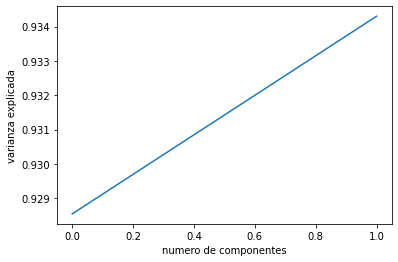

In [135]:
import matplotlib.pyplot as plt
%matplotlib inline

pca = PCA(n_components=2)
pca.fit_transform(matrix)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('numero de componentes')
plt.ylabel('varianza explicada')
plt.show()

Las dos primeras componentes contienen aprox. el 93% de la información.

In [137]:
pca = PCA(n_components=2)

result = pca.fit_transform(matrix)
result = pd.DataFrame(result)
result.columns = ['X', 'Y']
result['Palabra'] = matrix.index.values

#result

In [134]:
trace = go.Scatter(x=result['X'].values,
                   y=result['Y'].values,
                   text=result['Palabra'].values,
                   mode='markers') 

layout = go.Layout(title="Gráfico de palabras usando las dos primeras componentes")

fig = go.Figure(data=trace, layout=layout)
iplot(fig)

### Preguntas:

1. ¿Su modelo da buenos resultados? ¿Por qué sí o por qué no?
    - Lastimosamente por la cantidad tan baja de discursos el modelo no tiene un buen performance, sin embargo algunas 
      similitudes tienen sentido.

2. ¿Qué problemas encontró al realizar este taller?
    - Uno de los problemas principales fue en conseguir la base de datos, sin embargo al final me di cuenta que exisita 
      una super página de discursos, otro problema fue entender como funcionaba el wrod2vec.

## Base de los Simpson (kaggle) (opcional):

In [88]:
# lectura de archivo
simpson = pd.read_csv('simpsons_dataset.csv', sep=',')
simpson = simpson.dropna()
simpson.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [90]:
simpson['pre-procesado'] = simpson['spoken_words'].apply(lambda dialog: Preprocesamiento_eg(dialog))
simpson.head()

,raw_character_text,spoken_words,pre-procesado
0,Miss Hoover,"No, actually, it was a little of both. Sometim...","[actually, little, sometimes, disease, magazin..."
1,Lisa Simpson,Where's Mr. Bergstrom?,"[mr, bergstrom]"
2,Miss Hoover,I don't know. Although I'd sure like to talk t...,"[know, although, sure, like, talk, touch, less..."
3,Lisa Simpson,That life is worth living.,"[life, worth, living]"
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...,"[polls, open, end, recess, case, decided, put,..."


### Modelo Word2vec para los simpson:

In [91]:
%%time

model_simp = w2v.Word2Vec(simpson['pre-procesado'].values,
                            sg=1, # 1 para usar skip-gram, 0 para usar CBOW
                            seed=1, # 1 para tener resultados reproducibles y debugear
                            size=200, # el tamaño de los vectores de palabras, o neuronas
                            min_count=20, #mínimo de veces que ha de aparecer cada palabra, para ser considerada,
                            window=6) # ventana contextual de cada palabra

Wall time: 5 s


In [140]:
model_simp.wv.most_similar(positive=["selma"])

[('patty', 0.937950611114502),
 ('aunt', 0.8988243341445923),
 ('neighbor', 0.8169195652008057),
 ('doodily', 0.7962886095046997),
 ('mob', 0.7949644327163696),
 ('troy', 0.7851402759552002),
 ('kitty', 0.7815425395965576),
 ('bouvier', 0.7783036231994629),
 ('helen', 0.7782334089279175),
 ('diddily', 0.7732306122779846)]

In [95]:
model_simp.wv.similarity("lisa","saxophone")

0.7614702

In [106]:
model_simp.wv.doesnt_match(['homer', 'patty', 'selma'])

'homer'

In [112]:
model_simp.wv.most_similar(positive=["woman", "bart"], negative=["man"])

[('lisa', 0.7066479921340942),
 ('surprised', 0.6968368291854858),
 ('saxophone', 0.691015362739563),
 ('maggie', 0.6780656576156616),
 ('punish', 0.676245927810669),
 ('jessica', 0.6714988946914673),
 ('upset', 0.6685125827789307),
 ('asking', 0.6624780893325806),
 ('milhouse', 0.6623103618621826),
 ('lie', 0.6606845259666443)]

In [116]:
nearest_similarity_cosmul(model_simp, "bart", "man", "woman")

bart es a man, lo que lisa es a woman


In [141]:
X1 = model_simp[model_simp.wv.vocab]
matrix1 = pd.DataFrame(X1)
matrix1.index = model_simp.wv.vocab.keys()

# cada fila es una palabra y las columnas son el numero de dimensiones
# matrix1.head()

C:\Users\diego.diaz\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



In [142]:
pca = PCA(n_components=2)

result1 = pca.fit_transform(matrix1)
result1 = pd.DataFrame(result1)
result1.columns = ['X', 'Y']
result1['Palabra'] = matrix1.index.values

#result1

In [143]:
trace1 = go.Scatter(x=result1['X'].values,
                   y=result1['Y'].values,
                   text=result1['Palabra'].values,
                   mode='markers') 

layout1 = go.Layout(title="Gráfico de palabras usando las dos primeras componentes")

fig1 = go.Figure(data=trace1, layout=layout1)
iplot(fig1)